In [128]:
#!pip install sastrawi

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk

In [130]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abiyoso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [131]:
df = pd.read_csv('dataset_hateSpeech.csv', encoding='latin1')

print(df.head())

                                               Tweet  HS  Abusive  \
0  - disaat semua cowok berusaha melacak perhatia...   1        1   
1  RT USER: USER siapa yang telat ngasih tau elu?...   0        1   
2  41. Kadang aku berfikir, kenapa aku tetap perc...   0        0   
3  USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...   0        0   
4  USER USER Kaum cebong kapir udah keliatan dong...   1        1   

   HS_Individual  HS_Group  HS_Religion  HS_Race  HS_Physical  HS_Gender  \
0              1         0            0        0            0          0   
1              0         0            0        0            0          0   
2              0         0            0        0            0          0   
3              0         0            0        0            0          0   
4              0         1            1        0            0          0   

   HS_Other  HS_Weak  HS_Moderate  HS_Strong  
0         1        1            0          0  
1         0        0            0 

In [132]:
print(df.columns)

Index(['Tweet', 'HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion',
       'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak',
       'HS_Moderate', 'HS_Strong'],
      dtype='object')


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13169 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
 9   HS_Other       13169 non-null  int64 
 10  HS_Weak        13169 non-null  int64 
 11  HS_Moderate    13169 non-null  int64 
 12  HS_Strong      13169 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.3+ MB


In [134]:
# fokus ke kolom tweet dan HS aja

df = df[['Tweet', 'HS']]

In [135]:
print("\nMissing Values:\n", df.isnull().sum())
df = df.dropna(subset=['Tweet'])


Missing Values:
 Tweet    0
HS       0
dtype: int64


# **PREPROCESSING**

In [136]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stop_words = set(stopwords.words('indonesian'))

In [137]:
def preprocess(text):
    text = text.encode('ascii', 'ignore').decode() # hapus karakter non-ASCII
    text = text.lower() # lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # hapus link
    text = text.replace("url", '')
    text = re.sub(r'@\w+|\#','', text) # hapus mention/hashtag
    text = re.sub(r'[^a-zA-Z\s]', '', text) # hapus punctuation & angka
    text = re.sub(r'\n', '', text) # hapus new line
    text = re.sub('rt', '', text) # hapus "RT"
    text = re.sub(r'user', '', text)
    text = re.sub(r'\s+', ' ', text) # mengganti whitespace dengan single space
    text = text.strip() # hapus leading/trailing spaces
    tokens = text.split() # tokenize
    tokens = [stemmer.stem(word) for word in tokens]            # stemming
    return ' '.join(tokens)

In [138]:
df['clean_tweet'] = df['Tweet'].apply(preprocess)

### Slang Words Removal

In [139]:
import requests

In [140]:
slang_word = requests.get('https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt').text
dict_slang = eval(slang_word)

In [141]:
dict_slang.items()

dict_items([('@', 'di'), ('abis', 'habis'), ('ad', 'ada'), ('adlh', 'adalah'), ('afaik', 'as far as i know'), ('ahaha', 'haha'), ('aj', 'saja'), ('ajep-ajep', 'dunia gemerlap'), ('ak', 'saya'), ('akika', 'aku'), ('akkoh', 'aku'), ('akuwh', 'aku'), ('alay', 'norak'), ('alow', 'halo'), ('ambilin', 'ambilkan'), ('ancur', 'hancur'), ('anjrit', 'anjing'), ('anter', 'antar'), ('ap2', 'apa-apa'), ('apasih', 'apa sih'), ('apes', 'sial'), ('aps', 'apa'), ('aq', 'saya'), ('aquwh', 'aku'), ('asbun', 'asal bunyi'), ('aseekk', 'asyik'), ('asekk', 'asyik'), ('asem', 'asam'), ('aspal', 'asli tetapi palsu'), ('astul', 'asal tulis'), ('ato', 'atau'), ('au ah', 'tidak mau tahu'), ('awak', 'saya'), ('ay', 'sayang'), ('ayank', 'sayang'), ('b4', 'sebelum'), ('bakalan', 'akan'), ('bandes', 'bantuan desa'), ('bangedh', 'banget'), ('banpol', 'bantuan polisi'), ('banpur', 'bantuan tempur'), ('basbang', 'basi'), ('bcanda', 'bercanda'), ('bdg', 'bandung'), ('begajulan', 'nakal'), ('beliin', 'belikan'), ('bencong

In [142]:
slang_df = pd.DataFrame(dict_slang.items(), columns=['Old', 'New'])
slang_df.head()

,Old,New
0,@,di
1,abis,habis
2,ad,ada
3,adlh,adalah
4,afaik,as far as i know


In [143]:
# transform into key value in a dict
slang_dict = {}
for i, row in slang_df.iterrows():
  slang_dict.update({row['Old']: row['New']})

In [144]:
# remove trailing white space
slang_df['Old'] = slang_df['Old'].apply(lambda x: x.strip())
slang_df['New'] = slang_df['New'].apply(lambda x: x.strip())

In [145]:
def removeSlang(text):
    data = text.split()
    new_words = []
    for word in data:
        if word in slang_dict:
            new_words.append(slang_dict[word])
        else:
            new_words.append(word)
    return ' '.join(new_words)

In [146]:
df['clean_tweet'] = df['clean_tweet'].apply(removeSlang)

## Stop Words Removal

In [147]:
stop_words = set(stopwords.words('indonesian'))
custom_stopwords = {'iya', 'gak', 'orang', 'lu', 'gue', 'kok', 'nih', 'tuh', 'dong', 'sih', 'si', "nya", "ga"}
stop_words.update(custom_stopwords)
def removeStopWords(data):
    return data.apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))


In [148]:
df['clean_tweet'] = removeStopWords(df['clean_tweet'])

In [149]:
print("\nContoh hasil preprocessing:\n")
print(df[['Tweet', 'clean_tweet']].head())


Contoh hasil preprocessing:

                                               Tweet  \
0  - disaat semua cowok berusaha melacak perhatia...   
1  RT USER: USER siapa yang telat ngasih tau elu?...   
2  41. Kadang aku berfikir, kenapa aku tetap perc...   
3  USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...   
4  USER USER Kaum cebong kapir udah keliatan dong...   

                                         clean_tweet  
0  cowok usaha lacak perhati lantas remeh perhati...  
1  terlambat eluedan sarap gaul cigax jifla cal n...  
2  kadang berfikir percaya tuhan jatuh berkalikal...  
3                           akunnku mata sipit lihat  
4      kaum cebong kapir lihat dongok dongok hahahah  


# **EDA**

C:\Users\Abiyoso\AppData\Local\Temp\ipykernel_12420\608746153.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='HS', data=df, palette='pastel')


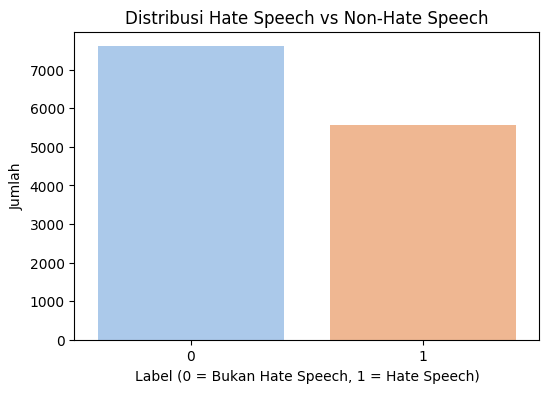

In [150]:
# distribusi label HS

plt.figure(figsize=(6,4))
sns.countplot(x='HS', data=df, palette='pastel')
plt.title('Distribusi Hate Speech vs Non-Hate Speech')
plt.xlabel('Label (0 = Bukan Hate Speech, 1 = Hate Speech)')
plt.ylabel('Jumlah')
plt.show()

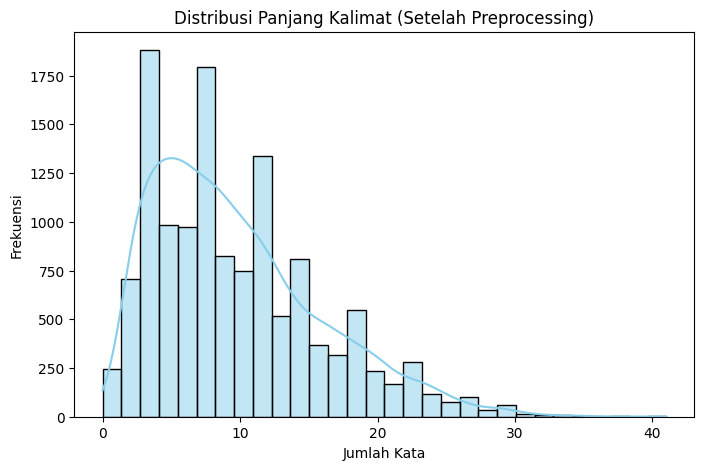

In [151]:
# distribusi panjang text

df['text_length'] = df['clean_tweet'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(df['text_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribusi Panjang Kalimat (Setelah Preprocessing)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

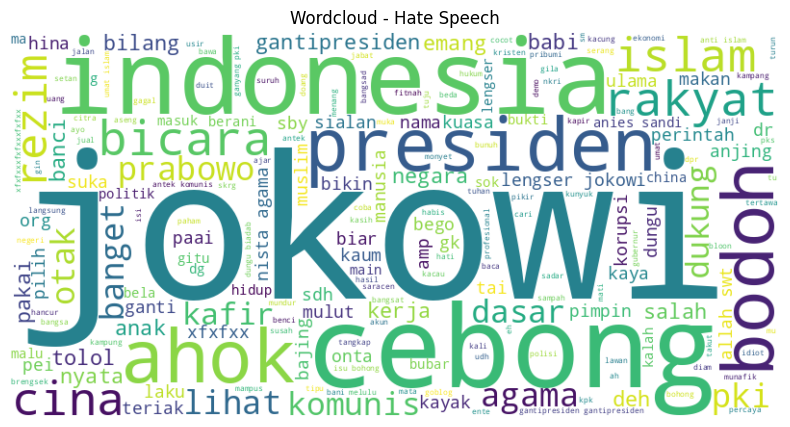

In [152]:
# wordcloud untuk Hate Speech
hate_speech = ' '.join(df[df['HS']==1]['clean_tweet'])
wordcloud_hs = WordCloud(width=800, height=400, background_color='white').generate(hate_speech)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_hs, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud - Hate Speech')
plt.show()

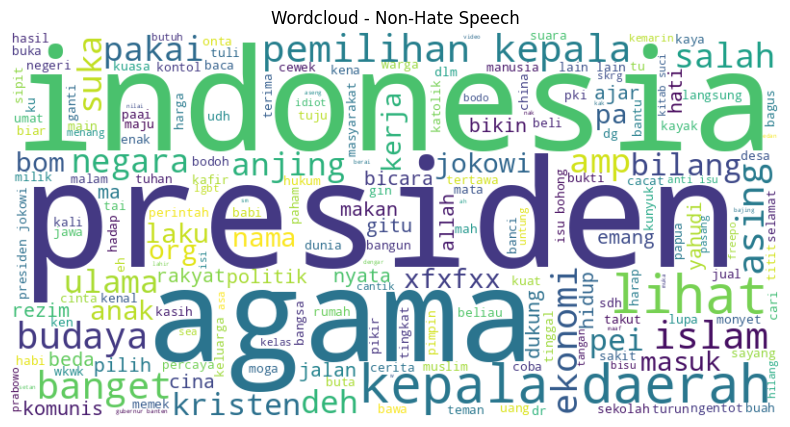

In [153]:
# wordcloud untuk Non-Hate Speech
non_hs = ' '.join(df[df['HS']==0]['clean_tweet'])
wordcloud_nonhs = WordCloud(width=800, height=400, background_color='white').generate(non_hs)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_nonhs, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud - Non-Hate Speech')
plt.show()

C:\Users\Abiyoso\AppData\Local\Temp\ipykernel_12420\2657194390.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='pastel')


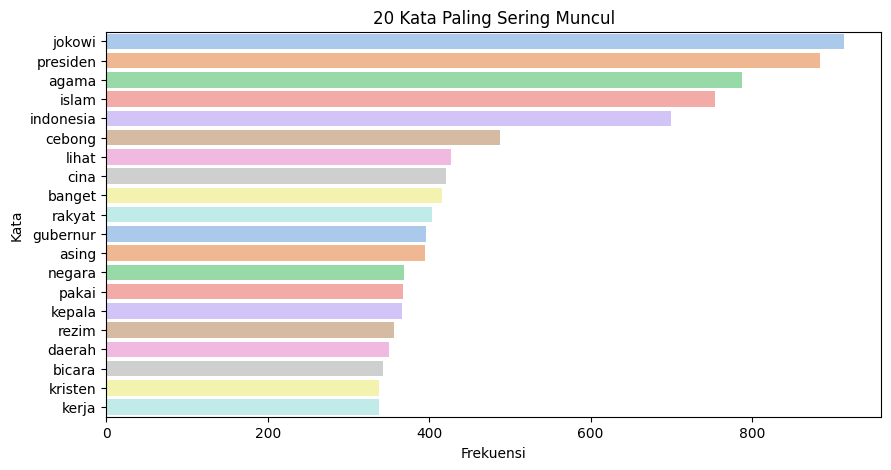

In [154]:
# frekuensi kata paling sering (top 20)
all_words = ' '.join(df['clean_tweet']).split()
counter = Counter(all_words)
common_words = counter.most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words), palette='pastel')
plt.title('20 Kata Paling Sering Muncul')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()